In [1]:
from collections import defaultdict
import itertools
import os
from pathlib import Path
import time

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_addons as tfa
import math

2022-07-26 20:41:34.594930: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


### Load dataset

Borrowing this code from [the notebook](https://github.com/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb) because it is not a tensorflow dataset still.

In [2]:
DOWNLOAD_ROOT = "http://download.tensorflow.org/data/"
FILENAME = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = keras.utils.get_file(FILENAME,
                                DOWNLOAD_ROOT + FILENAME,
                                cache_subdir="datasets/quickdraw",
                                extract=True)

In [3]:
quickdraw_dir = Path(filepath).parent
train_files = sorted([str(path) for path in quickdraw_dir.glob("training.tfrecord-*")])
eval_files = sorted([str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")])

In [4]:
train_files

['/home/jon/.keras/datasets/quickdraw/training.tfrecord-00000-of-00010',
 '/home/jon/.keras/datasets/quickdraw/training.tfrecord-00001-of-00010',
 '/home/jon/.keras/datasets/quickdraw/training.tfrecord-00002-of-00010',
 '/home/jon/.keras/datasets/quickdraw/training.tfrecord-00003-of-00010',
 '/home/jon/.keras/datasets/quickdraw/training.tfrecord-00004-of-00010',
 '/home/jon/.keras/datasets/quickdraw/training.tfrecord-00005-of-00010',
 '/home/jon/.keras/datasets/quickdraw/training.tfrecord-00006-of-00010',
 '/home/jon/.keras/datasets/quickdraw/training.tfrecord-00007-of-00010',
 '/home/jon/.keras/datasets/quickdraw/training.tfrecord-00008-of-00010',
 '/home/jon/.keras/datasets/quickdraw/training.tfrecord-00009-of-00010']

In [5]:
eval_files

['/home/jon/.keras/datasets/quickdraw/eval.tfrecord-00000-of-00010',
 '/home/jon/.keras/datasets/quickdraw/eval.tfrecord-00001-of-00010',
 '/home/jon/.keras/datasets/quickdraw/eval.tfrecord-00002-of-00010',
 '/home/jon/.keras/datasets/quickdraw/eval.tfrecord-00003-of-00010',
 '/home/jon/.keras/datasets/quickdraw/eval.tfrecord-00004-of-00010',
 '/home/jon/.keras/datasets/quickdraw/eval.tfrecord-00005-of-00010',
 '/home/jon/.keras/datasets/quickdraw/eval.tfrecord-00006-of-00010',
 '/home/jon/.keras/datasets/quickdraw/eval.tfrecord-00007-of-00010',
 '/home/jon/.keras/datasets/quickdraw/eval.tfrecord-00008-of-00010',
 '/home/jon/.keras/datasets/quickdraw/eval.tfrecord-00009-of-00010']

In [6]:
with open(quickdraw_dir / "eval.tfrecord.classes") as test_classes_file:
    test_classes = test_classes_file.readlines()
    
with open(quickdraw_dir / "training.tfrecord.classes") as train_classes_file:
    train_classes = train_classes_file.readlines()
    
assert train_classes == test_classes
class_names = [name.strip().lower() for name in train_classes]

In [7]:
sorted(class_names)

['aircraft carrier',
 'airplane',
 'alarm clock',
 'ambulance',
 'angel',
 'animal migration',
 'ant',
 'anvil',
 'apple',
 'arm',
 'asparagus',
 'axe',
 'backpack',
 'banana',
 'bandage',
 'barn',
 'baseball',
 'baseball bat',
 'basket',
 'basketball',
 'bat',
 'bathtub',
 'beach',
 'bear',
 'beard',
 'bed',
 'bee',
 'belt',
 'bench',
 'bicycle',
 'binoculars',
 'bird',
 'birthday cake',
 'blackberry',
 'blueberry',
 'book',
 'boomerang',
 'bottlecap',
 'bowtie',
 'bracelet',
 'brain',
 'bread',
 'bridge',
 'broccoli',
 'broom',
 'bucket',
 'bulldozer',
 'bus',
 'bush',
 'butterfly',
 'cactus',
 'cake',
 'calculator',
 'calendar',
 'camel',
 'camera',
 'camouflage',
 'campfire',
 'candle',
 'cannon',
 'canoe',
 'car',
 'carrot',
 'castle',
 'cat',
 'ceiling fan',
 'cell phone',
 'cello',
 'chair',
 'chandelier',
 'church',
 'circle',
 'clarinet',
 'clock',
 'cloud',
 'coffee cup',
 'compass',
 'computer',
 'cookie',
 'cooler',
 'couch',
 'cow',
 'crab',
 'crayon',
 'crocodile',
 'crow

In [8]:
def parse(data_batch):
    feature_descriptions = {
        "ink": tf.io.VarLenFeature(dtype=tf.float32),
        "shape": tf.io.FixedLenFeature([2], dtype=tf.int64),
        "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64)
    }
    examples = tf.io.parse_example(data_batch, feature_descriptions)
    flat_sketches = tf.sparse.to_dense(examples["ink"])
    sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
    lengths = examples["shape"][:, 0]
    labels = examples["class_index"][:, 0]
    return sketches, lengths, labels

def quickdraw_dataset(filepaths, batch_size=32, shuffle_buffer_size=None,
                      n_parse_threads=5, n_read_threads=5, cache=False,
                      reshuffle_each_iteration=True):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
    return dataset.prefetch(1)

In [9]:
train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10000)
val_set = quickdraw_dataset(eval_files[:5], shuffle_buffer_size=10000, reshuffle_each_iteration=False)
test_set = quickdraw_dataset(eval_files[5:])

2022-07-26 20:41:48.552428: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-26 20:41:48.982503: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22307 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:68:00.0, compute capability: 8.6


In [10]:
i, j, k = 0, 0, 0
for _ in train_set:
    i += 1
    
for _ in val_set:
    j += 1

for _ in test_set:
    k += 1

print(i, j, k)

107813 5390 5392


In [11]:
for sketch, length, label in train_set.unbatch().skip(2).take(1):
    print("sketch", sketch.shape, sketch[:length.numpy()+1, ...])
    print("length", length.shape, length)
    print("label", label.shape, label, class_names[label.numpy()])

sketch (87, 3) tf.Tensor(
[[ 0.04705882  0.03225806  0.        ]
 [ 0.21176472  0.04838711  0.        ]
 [ 0.10588235  0.          0.        ]
 [ 0.01568627 -0.03225806  0.        ]
 [-0.05098039 -0.07258067  0.        ]
 [-0.12941177 -0.06451613  0.        ]
 [-0.0745098   0.          0.        ]
 [-0.10196079  0.06451613  0.        ]
 [-0.01176471  0.08870968  0.        ]
 [ 0.01960785  0.2822581   0.        ]
 [ 0.01176471  0.12903225  0.        ]
 [ 0.01568627  0.02419353  0.        ]
 [ 0.28627452  0.          0.        ]
 [-0.00392157 -0.41129032  1.        ]
 [ 0.         -0.00806451  0.        ]
 [-0.13333334  0.43548384  0.        ]
 [-0.03529412 -0.1693548   0.        ]
 [-0.13333334 -0.2983871   1.        ]
 [ 0.39215687 -0.11290324  0.        ]
 [ 0.05882353 -0.05645162  0.        ]
 [ 0.08235297 -0.03225806  0.        ]
 [ 0.06274509  0.00806452  0.        ]
 [ 0.06274509  0.05645161  0.        ]
 [ 0.03921568  0.08870968  0.        ]
 [ 0.01960784  0.12096775  0.        ]

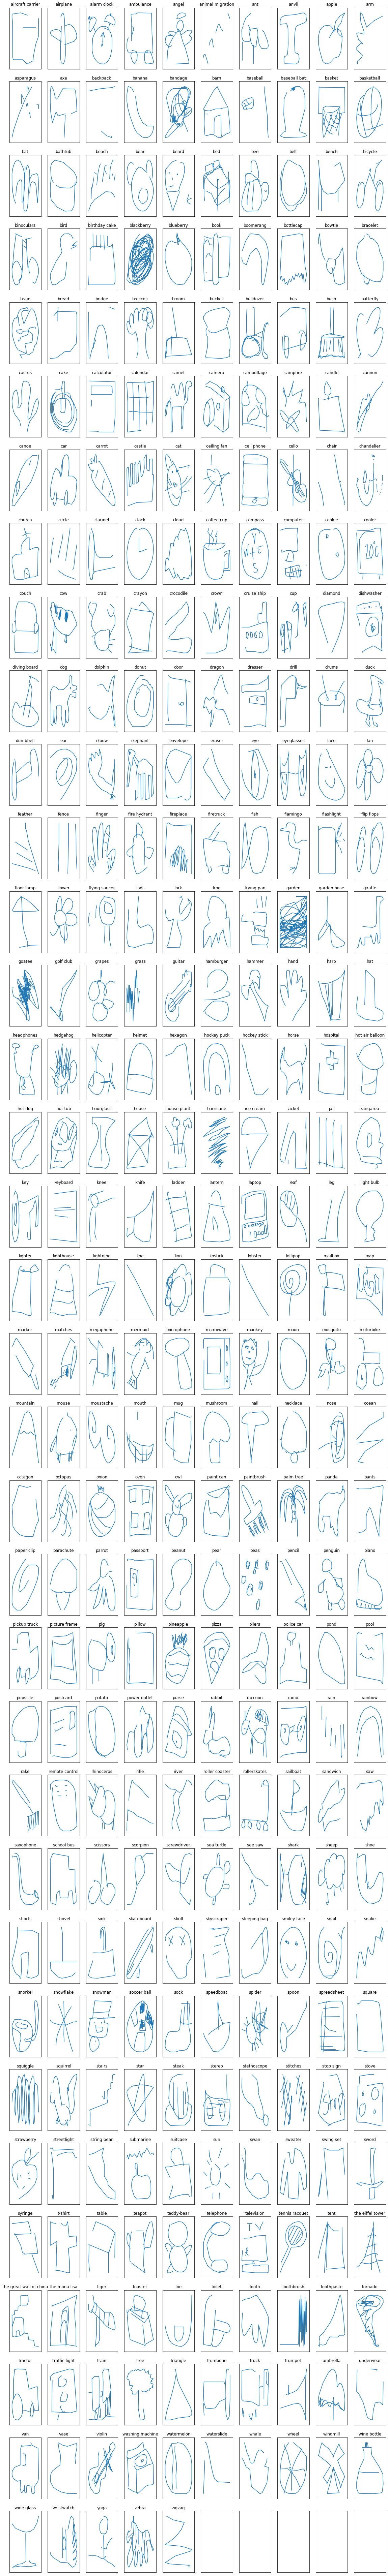

In [12]:
def sketch_to_line_collection(sketch, length):
    segments = []
    current_segment = []
    x, y, = 0, 0
    for dx, dy, stop in sketch[:length]:
        x += dx
        y -= dy
        current_segment.append((x, y))
        if stop:
            segments.append(current_segment)
            current_segment = []
    return mpl.collections.LineCollection(segments)

def plot_class_examples(ds, class_names):
    line_collections = {}
    
    for sketch, length, label in train_set.unbatch():
        if len(line_collections) == len(class_names):
            break
        label = label.numpy()
        if label in line_collections:
            continue
        lc = sketch_to_line_collection(sketch.numpy(), length.numpy())
        line_collections[label] = lc
    
    assert len(line_collections) == len(class_names)
    
    cols = 10
    rows = math.ceil(len(line_collections) / cols)
    fig, ax = plt.subplots(rows, cols, figsize=(2*cols, 4*rows))
    classes_with_labels = itertools.zip_longest(class_names, range(rows*cols), fillvalue="~")
    for i, (name, label) in enumerate(sorted(classes_with_labels, key=lambda x: x[0])):
        col = i % cols
        row = i // cols
        ax[row, col].set_xticks([])
        ax[row, col].set_yticks([])
        
        if i >= len(class_names):
            continue
        
        lc = line_collections[label]
        ax[row, col].set_title(name)
        ax[row, col].add_collection(lc)
        ax[row, col].autoscale()
        ax[row, col].margins(0.1)
        
    plt.show()
    
plot_class_examples(train_set, class_names)

In [13]:
class CustomTensorBoard(keras.callbacks.TensorBoard):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs.update({"learning_rate": self.model.optimizer.learning_rate})
        logs.update({"beta_1": self.model.optimizer.beta_1})
        for name, norm in self.model.optimizer.norms.items():
            logs.update({f"gradient_norm_{name}": norm.result()})
            norm.reset_state()
        super().on_epoch_end(epoch, logs)

In [14]:
def base_log_dir():
    return os.path.join(os.curdir, ".tflogs")

def get_tensorboard_cb(callback=keras.callbacks.TensorBoard):
    base_dir = base_log_dir()
    run_id = time.strftime("run_%Y_%m_%d_%H_%M_%S")
    run_dir = os.path.join(base_dir, run_id)
    return callback(run_dir)    

In [15]:
class GradientNormAdam(keras.optimizers.Nadam):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.norms = defaultdict(keras.metrics.Mean)
    
    def apply_gradients(self, grads_and_vars, **kwargs):
        op = super().apply_gradients(grads_and_vars, **kwargs)
        norms = [(v.name, tf.norm(g)) for g, v in grads_and_vars]
        for name, norm in norms:
            self.norms[name](norm)
        return op

In [36]:
def build_model(n_neurons=128, n_classes=345, learning_rate=1e-3, compile=True, optimizer=GradientNormAdam, clipnorm=None, dropout=0.2):
    model = keras.models.Sequential([
        keras.layers.Conv1D(32, kernel_size=5, strides=2, activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv1D(64, kernel_size=5, strides=2, activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv1D(128, kernel_size=3, strides=2, activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.GRU(n_neurons, return_sequences=True),
        keras.layers.GRU(n_neurons),
        keras.layers.Dense(n_classes, activation="softmax"),
    ])
    
    if compile:
        model.compile(
            loss="sparse_categorical_crossentropy",
            optimizer=optimizer(learning_rate=learning_rate, clipnorm=clipnorm),
            metrics=["accuracy"],
        )
    
    return model

In [17]:
class LearningRateCallback(keras.callbacks.Callback):
    def __init__(self, initial_learning_rate, final_learning_rate, steps):
        self.factor = math.exp(math.log(final_learning_rate/float(initial_learning_rate))/steps)
        self.losses = []
        self.learning_rates = []
    
    def on_batch_end(self, batch, logs):
        self.losses.append(logs.get("loss"))
        learning_rate = keras.backend.get_value(self.model.optimizer.learning_rate)
        self.learning_rates.append(learning_rate)
        keras.backend.set_value(self.model.optimizer.learning_rate, learning_rate*self.factor)

def find_best_learning_rate(
    train_set,
    val_set,
    compiled_model, 
    n_steps=500,
    learning_rate_min=1e-5, 
    learning_rate_max=1e-1,
    ):
    keras.backend.clear_session()
    np.random.seed(42)
    tf.random.set_seed(42)  
    
    learning_rate_callback = LearningRateCallback(learning_rate_min, learning_rate_max, n_steps)
    
    history = compiled_model.fit(
      train_set,
      epochs=1,
      steps_per_epoch=n_steps,
      validation_data=val_set,
      callbacks=[learning_rate_callback],
    )
    
    
    learning_rates = np.array(learning_rate_callback.learning_rates)
    losses = np.array(learning_rate_callback.losses)
    idx = losses < 10000
    learning_rates_clean = learning_rates[idx]
    losses_clean = losses[idx]
    
    plt.plot(learning_rates_clean, losses_clean)
    best_idx = np.argmin(losses_clean)
    best_learning_rate = learning_rates[best_idx] / 10.
    return best_learning_rate

In [18]:
def train_model(
    train_set, 
    val_set, 
    name, 
    compiled_model, 
    callbacks=None,
    n_epochs=500,
    steps_per_epoch=None,
    batch_size=32,
    tensorboard_callback=keras.callbacks.TensorBoard,
    ):
    callbacks = callbacks or []
    keras.backend.clear_session()
    np.random.seed(42)
    tf.random.set_seed(42)
    
    builtin_callbacks = [
        keras.callbacks.ModelCheckpoint(f"{name}_model.h5", save_best_only=True),
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        get_tensorboard_cb(callback=tensorboard_callback),
    ]
    
    history = compiled_model.fit(
        train_set,
        epochs=n_epochs,
        steps_per_epoch=steps_per_epoch,
        batch_size=batch_size,
        validation_data=val_set,
        callbacks=callbacks + builtin_callbacks,
    )

In [20]:
model = build_model()
# model.summary()

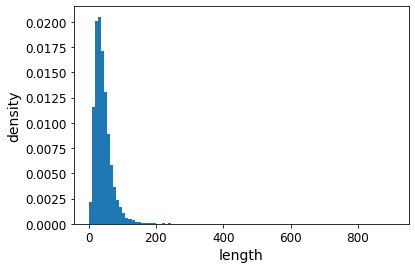

In [21]:
lengths = np.concatenate([lengths for _, lengths, _ in train_set.take(1000)])
plt.hist(lengths, bins=100, density=True)
plt.xlabel("length")
plt.ylabel("density")
plt.show()

In [22]:
def crop_sequence(dataset, cutoff=100):
    return dataset.map(lambda sketches, lengths, labels: (sketches[:, :cutoff], labels))
    
cropped_train_set = crop_sequence(train_set)
cropped_val_set = crop_sequence(val_set)
cropped_test_set = crop_sequence(test_set)

500/500 [==============================] - 18s 25ms/step - loss: 20.4277 - accuracy: 0.0049 - val_loss: 143.8697 - val_accuracy: 0.0000e+00


0.000524807395413518

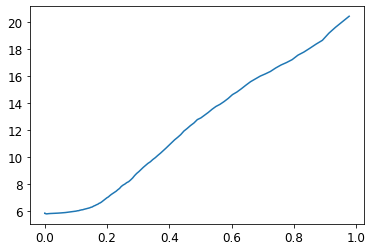

In [38]:
model = build_model(learning_rate=1e-5, clipnorm=1.0)
find_best_learning_rate(cropped_train_set, cropped_val_set.take(1), model, learning_rate_min=1e-5, learning_rate_max=1e0)

In [40]:
5e-4

0.0005

In [ ]:
model = build_model(learning_rate=5e-4, clipnorm=1.0)
train_model(cropped_train_set.repeat(10), cropped_val_set.take(500), "adam_conv1d_bn_3_gru_2_dense_1", model, steps_per_epoch=1500)

Epoch 1/500
1500/1500 [==============================] - 41s 25ms/step - loss: 5.2991 - accuracy: 0.0274 - val_loss: 4.9416 - val_accuracy: 0.0503
Epoch 2/500
1500/1500 [==============================] - 36s 24ms/step - loss: 4.6559 - accuracy: 0.0773 - val_loss: 4.3846 - val_accuracy: 0.1060
Epoch 3/500
1500/1500 [==============================] - 36s 24ms/step - loss: 3.6606 - accuracy: 0.2102 - val_loss: 3.5472 - val_accuracy: 0.2351
Epoch 6/500
1500/1500 [==============================] - 36s 24ms/step - loss: 3.4608 - accuracy: 0.2440 - val_loss: 3.3715 - val_accuracy: 0.2638
Epoch 7/500
1500/1500 [==============================] - 36s 24ms/step - loss: 2.2834 - accuracy: 0.4586 - val_loss: 2.2447 - val_accuracy: 0.4651
Epoch 27/500
1500/1500 [==============================] - 36s 24ms/step - loss: 2.0169 - accuracy: 0.5127 - val_loss: 1.9758 - val_accuracy: 0.5204
Epoch 43/500
1500/1500 [==============================] - 36s 24ms/step - loss: 2.0148 - accuracy: 0.5142 - val_loss: